# Introduction

Github project adapted from content taught in DSC 190: Spring '21 with Justin Eldridge

In this notebook, I will demonstrate how simple Linear Algebra can be utilized for image element detection applications. For example, we can use PCA to find eyeglass wearers

In [2]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import scipy.spatial
import sklearn.manifold

The cell below downloads the "Olivetti Faces" dataset. This dataset contains 400 images of faces. 40 individuals are in the dataset, each contributing 10 images. The pictures were taken at AT&T Labs in Cambridge in the early 1990s.

In [3]:
data = sklearn.datasets.fetch_olivetti_faces()['data']
data.shape

(400, 4096)

Each image is 64 x 64. We can visualize an image as follows:

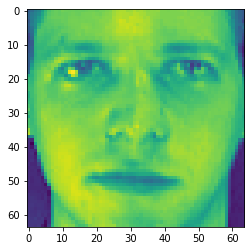

In [4]:
example_image = data[0]
plt.imshow(example_image.reshape((64, 64)))

Some of the people in this dataset are wearing glasses -- but who? We can use PCA to find eyeglass wearers without using any labels whatsoever. PCA can "discover" this automatically.

# Detecting Facial Features

We will compute the top ten eigenvectors of the data and plot each of these eigenvectors as a 64 x 64 image to discover one which carries information about eyeglass wearers 

In [5]:
eigen_vals, eigen_vecs = np.linalg.eigh(np.cov(data.T))
top_10 = eigen_vecs[:, -10:][:, ::-1].T

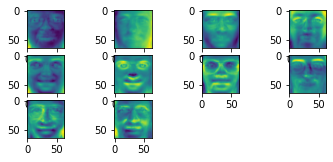

In [6]:
fig = plt.figure()
for i in range(10):
    fig.add_subplot(5, 4, i+1)
    image = top_10[i]
    plt.imshow(image.reshape((64, 64)))

Although these images are pretty terrifying, each carries information on a different prominent facial feature.
we can observe that eyeglasses are a prominent feature of the 7th eigenvector out of the 10 above

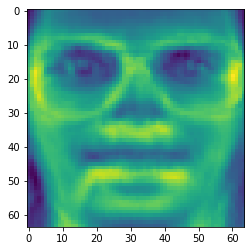

In [7]:
image = top_10[6].reshape((64, 64))
plt.imshow(image)

### Detecting all eyeglass wearers

We will take the dot product of the chosen eigenvector with every image in the data set and plot the 20 images whose dot product with the eigenvector is the largest in absolute value.

In [19]:
u = top_10[6]
dots = np.abs(np.dot(data[:, np.newaxis], u))
vals = {i: dots[i] for i in range(len(dots))}
top_20 = sorted(vals.items(), key = lambda kv:[kv[1], kv[0]], reverse=True)[:20]
indices = [i[0] for i in top_20]

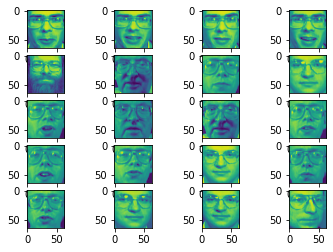

In [20]:
fig = plt.figure()
for i in range(len(indices)):
    fig.add_subplot(5, 4, i+1)
    image = data[indices[i]]
    plt.imshow(image.reshape((64, 64)))

And just like that, we have detected all eyeglass wearers using just eigenvectors and dot products

# Detecting Similarities

Say we wish to detect similar faces, emotions or facial features. Is someone smiling or serious? Bearded or clean shaven? We can use the concept of Spectral Embeddings using Laplacian Eigenmaps to embed the data and visualize these similarities and differences

We shall embed all images into $\mathbb R^2$ by computing a fully-connected Gaussian similarity matrix with $\sigma = 10$ and a normalized graph Laplacian. For this problem, we will use `sklear.manifold.spectral_embedding` to perform the spectral embedding with Laplacian eigenmaps.

In [8]:
distances = scipy.spatial.distance_matrix(data, data)
sigma = 10
W = np.exp(-distances**2 / sigma**2)

embedding = sklearn.manifold.spectral_embedding(W, n_components=2, norm_laplacian=True)

The cell below will draw a scatter plot of your embedding in which each scatter plot point is replaced by the image it represents. You can use it to get a sense of whether your answer is correct.

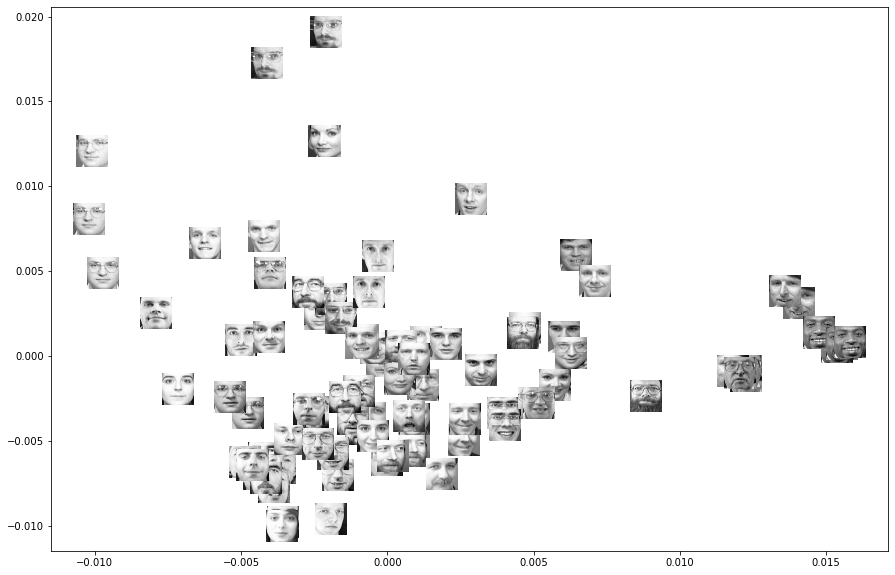

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_image(ax, x, y, image, zoom=1, alpha=1):
    oi = OffsetImage(image, zoom=zoom, alpha=alpha, cmap='Greys_r')
    ab = AnnotationBbox(oi, (x, y), frameon=False, xycoords='data')
    ax.add_artist(ab)
     
fig, ax = plt.subplots(figsize=(15, 10))
np.random.seed(42)
ix = np.random.choice(len(data), size=100)
Z = embedding
ax.scatter(Z[ix, 0], Z[ix, 1], alpha=0, color='C0')
# ax.scatter(Z[ix_k, 0], np.zeros(len(ix_k)), alpha=1, color='C3')

for i in ix:
    image = data[i].reshape((64, -1))
    x_coord = Z[i,0]
    y_coord = Z[i,1]
    scatter_image(ax, x_coord, y_coord, image, zoom=.5, alpha=1)

The spectral embedding above seems to not only have clustered the same people's faces together, but has also selected two facial features to visualize along both axes. Although these features are not always well defined, the x-axis in the above plot seems to depict faces from serious to smiling when moving from left to right while the y-axis seems to depict the presence or absence of facial hair